In [10]:
import numpy as np
import cv2 # OpenCV biblioteka
import matplotlib
import matplotlib.pyplot as plt
# iscrtavanje slika i grafika unutar samog browsera
%matplotlib inline 
# prikaz vecih slika 
matplotlib.rcParams['figure.figsize'] = 16,12
# keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD

from sklearn.cluster import KMeans

from collections import deque
import time
from threading import Thread
import os

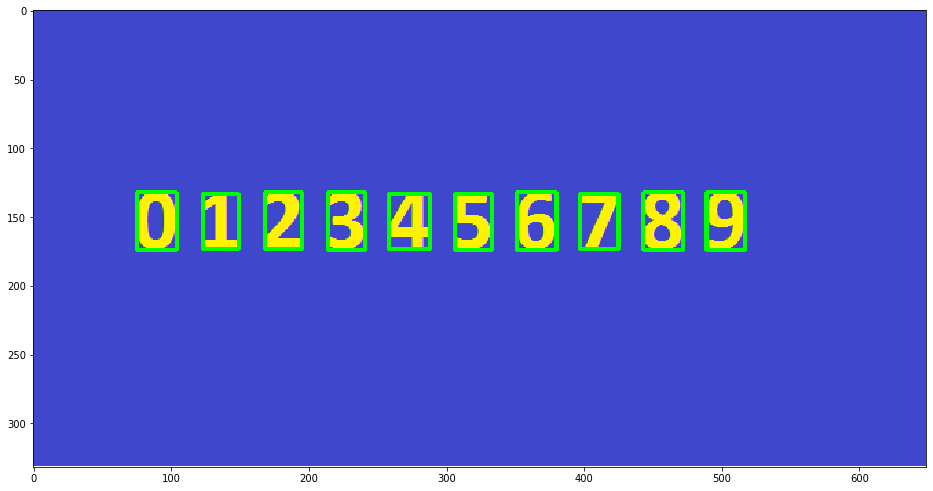

In [22]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def image_bin(image_gs):
    height, width = image_gs.shape[0:2]
    image_binary = np.ndarray((height, width), dtype=np.uint8)
    ret, image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin

def invert(image):
    return 255-image

def display_image(image, color=False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')

def dilate(image):
    kernel = np.ones((3, 3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)

def erode(image):
    kernel = np.ones((3, 3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

def resize_region(region):
    return cv2.resize(region, (28, 28), interpolation=cv2.INTER_NEAREST)

def select_roi(image_orig, image_bin):
    contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    sorted_regions = [] # lista sortiranih regiona po X osi
    regions_array = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour) # koordinate i velicina granicnog pravougaonika
        area = cv2.contourArea(contour)
        if area > 100 and h < 100 and h > 15 and w > 20:
            # kopirati [y:y+h+1, x:x+w+1] sa binarne slike i smestiti u novu sliku
            # oznaciti region pravougaonikom na originalnoj slici sa rectangle funkcijom
            region = image_bin[y:y+h+1, x:x+w+1]
            regions_array.append([resize_region(region), (x, y, w, h)])
            cv2.rectangle(image_orig, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    regions_array = sorted(regions_array, key=lambda x: x[1][0])
    sorted_regions = [region[0] for region in regions_array]
    return image_orig, sorted_regions

def scale_to_range(image):
    return image/255

def matrix_to_vector(image):
    return image.flatten()

def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        scale = scale_to_range(region)
        ready_for_ann.append(matrix_to_vector(scale))
    return ready_for_ann

def convert_output(alphabet):
    nn_outputs = []
    for index in range(len(alphabet)):
        output = np.zeros(len(alphabet))
        output[index] = 1
        nn_outputs.append(output)
    return np.array(nn_outputs)

def create_ann(output_size):
    ann = Sequential()
    ann.add(Dense(128, input_dim=784, activation='sigmoid'))
    ann.add(Dense(output_size, activation='sigmoid'))
    return ann

def train_ann(ann, X_train, y_train, epochs):
    X_train = np.array(X_train, np.float32) # dati ulaz
    y_train = np.array(y_train, np.float32) # zeljeni izlazi na date ulaze
    
    print("\nTraining started...")
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)
    ann.fit(X_train, y_train, epochs=epochs, batch_size=1, verbose=0, shuffle=False)
    print("\nTraining completed...")
    return ann

def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]

def display_result(outputs, alphabet):
    result = []
    for output in outputs:
        result.append(alphabet[winner(output)])
    return result

image_color = load_image('images/brojevi.png')
img = image_bin(image_gray(image_color))
img_bin = erode(dilate(img))
selected_regions, numbers = select_roi(image_color.copy(), img_bin)
display_image(selected_regions)

In [23]:
alphabet = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

inputs = prepare_for_ann(numbers)
outputs = convert_output(alphabet)
ann = create_ann(output_size=10)
ann = train_ann(ann, inputs, outputs, epochs=2000)


Training started...

Training completed...


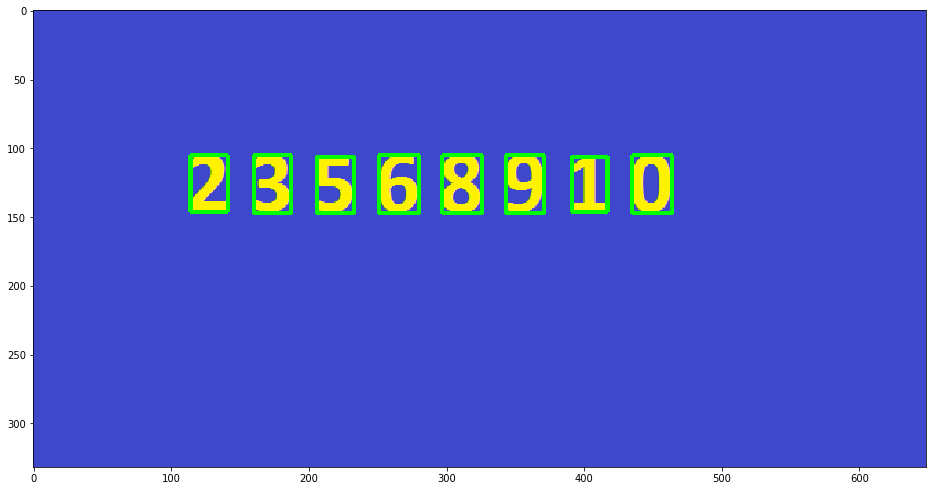

In [24]:
test_color = load_image('images/test.png')
test = image_bin(image_gray(test_color))
test_bin = erode(dilate(test))
selected_test, test_numbers = select_roi(test_color.copy(), test_bin)
display_image(selected_test)

In [25]:
test_inputs =  prepare_for_ann(test_numbers)
result = ann.predict(np.array(test_inputs, np.float32))
print(display_result(result, alphabet))

[2, 3, 5, 6, 8, 9, 1, 0]


In [26]:
def selectuh(image_orig_c, image_bin):
    contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    sorted_regions = [] # lista sortiranih regiona po X osi
    regions_array = []
    image_orig = image_orig_c.copy()
    i = 1
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour) # koordinate i velicina granicnog pravougaonika
        area = cv2.contourArea(contour)
        if h>40 and w>40 and w<70 and h<70:
            region = image_bin[y:y+h+1, x:x+w+1]
            regions_array.append([resize_region(region), (x, y, w, h)])
            cv2.rectangle(image_orig, (x, y), (x + w, y + h), (0, 255, 0), 2)
            i += 1
    
    #regions_array = sorted(regions_array, key=lambda x: x[1][0])
    regions_array = sorted(regions_array, key=lambda x: x[1][1])
    sorted_rectangles = [region[1] for region in regions_array]
    for i in range(len(sorted_rectangles)):
        for j in range(i+1, len(sorted_rectangles)):
            current_i = sorted_rectangles[i]
            current_j = sorted_rectangles[j]
            if current_i[1]-5 < current_j[1] and current_j[1] < current_i[1]+5 and current_j[0] < current_i[0]:
                t1 = sorted_rectangles[i]
                sorted_rectangles[i] = sorted_rectangles[j]
                sorted_rectangles[j] = t1
                t2 = regions_array[i]
                regions_array[i] = regions_array[j]
                regions_array[j] = t2
                
    sorted_regions = [region[0] for region in regions_array]
    return image_orig, sorted_regions

def resize_region(region):
    return cv2.resize(region, (28, 28), interpolation=cv2.INTER_NEAREST)

def scale_to_range(image):
    return image/255

def matrix_to_vector(image):
    return image.flatten()

def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        scale = scale_to_range(region)
        ready_for_ann.append(matrix_to_vector(scale))
    return ready_for_ann

def convert_output(alphabet):
    nn_outputs = []
    for index in range(len(alphabet)):
        output = np.zeros(len(alphabet))
        output[index] = 1
        nn_outputs.append(output)
    return np.array(nn_outputs)

def create_ann(output_size):
    ann = Sequential()
    ann.add(Dense(128, input_dim=18, activation='sigmoid'))
    ann.add(Dense(output_size, activation='sigmoid'))
    return ann


def train_ann(ann, X_train, y_train, epochs):
    X_train = np.array(X_train, np.float32) # dati ulaz
    y_train = np.array(y_train, np.float32) # zeljeni izlazi na date ulaze
    
    print("\nTraining started...")
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)
    ann.fit(X_train, y_train, epochs=epochs, batch_size=1, verbose=0, shuffle=False)
    print("\nTraining completed...")
    return ann

def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]

def display_result(outputs, alphabet):
    result = []
    for output in outputs:
        result.append(alphabet[winner(output)])
    return result

def result_to_numbers(result):
    numbers = [0, 0, 0, 0, 0, 0, 0]
    alpha = list(map(str,result))
    if result[-1] == 0 and result[-2] == 0:
        numbers[6] = 100
        numbers[5] = int(alpha[-5]+alpha[-4])
        numbers[4] = result[-6]
        numbers[3] = result[-7]
        numbers[2] = result[-8]
        numbers[1] = result[-9]
        numbers[0] = int(alpha[-12]+alpha[-11]+alpha[-10])
    else:
        numbers[6] = int(alpha[-2]+alpha[-1])
        numbers[5] = int(alpha[-4]+alpha[-3])
        numbers[4] = result[-5]
        numbers[3] = result[-6]
        numbers[2] = result[-7]
        numbers[1] = result[-8]
        numbers[0] = int(alpha[-11]+alpha[-10]+alpha[-9])
    return numbers

In [81]:
def read_stats():
    file1 = open('stats/numbers.txt', 'r')
    lines = file1.readlines()
    stats = []
    for line in lines:
        stat = {}
        parsed_line = line.strip().split('|')
        stat['filename'] = parsed_line[0]
        stat['numbers'] = [int(i) for i in parsed_line[1].split(',')] 
        stats.append(stat)
    
    return stats
    
stats = read_stats()

In [82]:
stat_counter = 0
folder = 'sc_images'
result_numbers_list = []
for stat in stats:
    img = load_image(os.path.join(folder,stat['filename']))
    img_proba = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # konvertovanje iz BGR u RGB model boja (OpenCV ucita sliku kao BGR)
    #plt.imshow(img_proba)  # prikazivanje slike
    img_proba_gray = cv2.cvtColor(img_proba, cv2.COLOR_RGB2GRAY)
    #plt.imshow(img_proba_gray, 'gray')
    ret, image_proba_bin = cv2.threshold(img_proba_gray, 230, 255, cv2.THRESH_BINARY) 
    #plt.imshow(image_proba_bin, 'gray')
    kernel = np.ones((3, 3)) # strukturni element 3x3 blok
    img_proba_dil = cv2.dilate(image_proba_bin, kernel, iterations=1)
    img_proba_close = cv2.erode(img_proba_dil, kernel, iterations=2)
    #plt.imshow(img_proba_close, 'gray')
    selected_test1, test_numbers1 = selectuh(img_proba.copy(), img_proba_close)
    #display_image(selected_test1)
    test_inputs1 =  prepare_for_ann(test_numbers1)
    result1 = ann.predict(np.array(test_inputs1, np.float32))
    displayed_result = display_result(result1, alphabet)
    #print(displayed_result)
    result_numbers = result_to_numbers(displayed_result)
 
    if result_numbers == stat['numbers']:
        stat_counter += 1
        result_numbers_list.append(result_numbers)
    else:
        print(result_numbers)
        print(stat['numbers'])
        print('***********************')
    
print("Procenat uspesnosti: {}%".format(stat_counter/len(stats)*100))

Procenat uspesnosti: 100.0%


In [29]:
class Expression:

    def __init__(self, operand1, operand2, operation, history, numbers_used, expressions_used):
        self.operand1 = operand1
        self.operand2 = operand2
        self.operation = operation
        self.is_commutative = self.set_commutative()
        self.result = self.calculate()
        self.history = history
        self.numbers_used = numbers_used
        self.expressions_used = expressions_used

    def calculate(self):
        if self.operation == "+":
            return self.operand1 + self.operand2
        elif self.operation == "-":
            return self.operand1 - self.operand2
        elif self.operation == "*":
            return self.operand1 * self.operand2
        else:
            return self.operand1 / self.operand2

    def set_commutative(self):
        if self.operation == "+":
            return True
        elif self.operation == "*":
            return True
        else:
            return False

    def used_conflict(self, used):
        for number in self.numbers_used:
            for conflicting in used:
                if number == conflicting:
                    return True
        return False

    def __eq__(self, other):
        if type(other) != Expression:
            return False
        if self.operand1 == other.operand1 and self.operand2 == other.operand2 and self.operation == other.operation:
            return True
        elif self.operand1 == other.operand2 and self.operand2 == other.operand1 \
                and self.operation == other.operation and self.is_commutative:
            return True
        else:
            return False

    def __hash__(self):
        if self.is_commutative:
            return hash(self.operand1) ^ hash(self.operand2) ^ hash(self.operation)

        else:
            return (hash(self.operand1) ^ hash(self.operand2) ^ hash(self.operation)) ^ \
                   hash((self.operand1, self.operand2, self.operation))

    def __repr__(self):
        return "(" + str(self.operand1) + " " + str(self.operation) + " " + str(self.operand2) + ")"


In [30]:
def test():
    exp1 = Expression(1, 2, "+", None, None, None)
    exp2 = Expression(1, 2, "+", None, None, None)
    exp3 = Expression(2, 1, "+", None, None, None)
    exp4 = Expression(6, 6, "+", None, None, None)
    print("exp1 == exp2\nExpected True, received: ", exp1 == exp2)
    print("exp1 == exp3\nExpected True, received: ", exp1 == exp3)
    print("exp1 == exp4\nExpected False, received: ", exp1 == exp4)

    print("\n\n========HASH========\n\n")
    exp1_hash = hash(exp1)
    exp2_hash = hash(exp2)
    exp3_hash = hash(exp3)
    exp4_hash = hash(exp4)
    # print(exp1_hash)
    # print(exp2_hash)
    # print(exp3_hash)
    # print(exp4_hash)
    print("exp1_hash == exp2_hash\nExpected True, received: ", exp1_hash == exp2_hash)
    print("exp1_hash == exp3_hash\nExpected True, received: ", exp1_hash == exp3_hash)
    print("exp1_hash == exp4_hash\nExpected False, received: ", exp1_hash == exp4_hash)
    print("\n\n")

    exp5 = Expression(1, 2, "-", None, None, None)
    exp6 = Expression(1, 2, "-", None, None, None)
    exp7 = Expression(2, 1, "-", None, None, None)
    exp8 = Expression(6, 6, "-", None, None, None)
    print("exp5 == exp6\nExpected True, received: ", exp5 == exp6)
    print("exp5 == exp7\nExpected False, received: ", exp5 == exp7)
    print("exp5 == exp8\nExpected False, received: ", exp5 == exp8)

    print("\n\n========HASH========\n\n")
    exp5_hash = hash(exp5)
    exp6_hash = hash(exp6)
    exp7_hash = hash(exp7)
    exp8_hash = hash(exp8)
    # print(exp5_hash)
    # print(exp6_hash)
    # print(exp7_hash)
    # print(exp8_hash)
    print("exp5_hash == exp6_hash\nExpected True, received: ", exp5_hash == exp6_hash)
    print("exp5_hash == exp7_hash\nExpected False, received: ", exp5_hash == exp7_hash)
    print("exp5_hash == exp8_hash\nExpected False, received: ", exp5_hash == exp8_hash)



In [31]:
test()

exp1 == exp2
Expected True, received:  True
exp1 == exp3
Expected True, received:  True
exp1 == exp4
Expected False, received:  False


========HASH========


exp1_hash == exp2_hash
Expected True, received:  True
exp1_hash == exp3_hash
Expected True, received:  True
exp1_hash == exp4_hash
Expected False, received:  False



exp5 == exp6
Expected True, received:  True
exp5 == exp7
Expected False, received:  False
exp5 == exp8
Expected False, received:  False


========HASH========


exp5_hash == exp6_hash
Expected True, received:  True
exp5_hash == exp7_hash
Expected False, received:  False
exp5_hash == exp8_hash
Expected False, received:  False


In [32]:
def history_builder(first, second, operation):
    if type(first) == int or type(first) == float and type(second) == int or type(second) == float:
        return "(" + str(first) + " " + operation + " " + str(second) + ")"
    elif type(first) == Expression and type(second) == int or type(second) == float:
        return "(" + first.history + " " + operation + " " + str(second) + ")"
    elif type(first) == int or type(first) == float and type(second) == Expression:
        return "(" + str(second) + " " + operation + " " + first.history + ")"
    else:
        return "(" + first.history + " " + operation + " " + second.history + ")"


In [33]:
def union(first, second):
    return first.union(second)


In [53]:
def countdown():
    time.sleep(90)
    global time_up
    time_up = False

In [54]:
operation_signs = ["+", "-", "-", "*", "/", "/"]
queue = deque()
valid_expressions = set()
current_best = None
time_up = False

In [69]:
def do_operations(first, second, first_exp, second_exp, target, indicator):
    global current_best
    for operation_index in range(len(operation_signs)):
        new_value = -1
        operand1 = -1
        operand2 = -1
        new_history = ""
        if operation_index == 0:
            new_value = first + second
            operand1 = first
            operand2 = second
            if indicator == 0:
                new_history = history_builder(operand1, operand2, operation_signs[operation_index])
            elif indicator == 1:
                new_history = history_builder(first_exp, second, operation_signs[operation_index])
            else:
                new_history = history_builder(first_exp, second_exp, operation_signs[operation_index])
        elif operation_index == 1:
            new_value = first - second
            operand1 = first
            operand2 = second
            if indicator == 0:
                new_history = history_builder(operand1, operand2, operation_signs[operation_index])
            elif indicator == 1:
                new_history = history_builder(first_exp, second, operation_signs[operation_index])
            else:
                new_history = history_builder(first_exp, second_exp, operation_signs[operation_index])
        elif operation_index == 2:
            new_value = second - first
            operand1 = second
            operand2 = first
            if indicator == 0:
                new_history = history_builder(operand1, operand2, operation_signs[operation_index])
            elif indicator == 1:
                new_history = history_builder(second, first_exp, operation_signs[operation_index])
            else:
                new_history = history_builder(second_exp, first_exp, operation_signs[operation_index])
        elif operation_index == 3:
            new_value = first * second
            operand1 = first
            operand2 = second
            if indicator == 0:
                new_history = history_builder(operand1, operand2, operation_signs[operation_index])
            elif indicator == 1:
                new_history = history_builder(first_exp, second, operation_signs[operation_index])
            else:
                new_history = history_builder(first_exp, second_exp, operation_signs[operation_index])
        elif operation_index == 4:
            if second != 0 and first % second == 0:
                new_value = round(first / second)
                operand1 = first
                operand2 = second
                if indicator == 0:
                    new_history = history_builder(operand1, operand2, operation_signs[operation_index])
                elif indicator == 1:
                    new_history = history_builder(first_exp, second, operation_signs[operation_index])
                else:
                    new_history = history_builder(first_exp, second_exp, operation_signs[operation_index])
        else:
            if first != 0 and second % first == 0:
                new_value = round(second / first)
                operand1 = second
                operand2 = first
                if indicator == 0:
                    new_history = history_builder(operand1, operand2, operation_signs[operation_index])
                elif indicator == 1:
                    new_history = history_builder(second, first_exp, operation_signs[operation_index])
                else:
                    new_history = history_builder(second_exp, first_exp, operation_signs[operation_index])

        if new_value >= 0:
            if indicator == 0:
                new_used = union({first_exp}, {second_exp})
                new_expressions_used = union(set(), set())
            elif indicator == 1:
                new_used = union(first_exp.numbers_used, {second_exp})
                new_expressions_used = union(first_exp.expressions_used, set())
            else:
                new_used = union(first_exp.numbers_used, second_exp.numbers_used)
                new_expressions_used = union(first_exp.expressions_used, second_exp.expressions_used)

            expression = Expression(operand1, operand2, operation_signs[operation_index],
                                    new_history, new_used, new_expressions_used)
            if current_best is None:
                current_best = expression
            elif abs(target - current_best.result) > abs(target - expression.result):
                current_best = expression

            expression.expressions_used.add(expression)
            if expression.result == target:
                return expression
            queue.append(expression)
            valid_expressions.add(expression)

    return None

In [70]:
def solve(numbers, target):
    for number in numbers:
        if number == target:
            return Expression(number, None, None, None, None, None)
    for i in range(len(numbers)):
        for j in range(len(numbers)):
            if i != j:
                resulting_expression = do_operations(numbers[i], numbers[j], i, j, target, 0)
                if resulting_expression is not None:
                    return resulting_expression
    
    while len(queue) != 0 and not time_up:
        curr_exp = queue.popleft()

        for number_index in range(len(numbers)):

            if number_index in curr_exp.numbers_used:
                continue

            resulting_expression = do_operations(curr_exp.result, numbers[number_index], curr_exp,
                                                 number_index, target, 1)
            if resulting_expression is not None:
                return resulting_expression

        exp_iterator = valid_expressions.copy()
        for exp in exp_iterator:

            if exp in curr_exp.expressions_used or curr_exp.used_conflict(exp.numbers_used):
                continue

            resulting_expression = do_operations(curr_exp.result, exp.result, curr_exp, exp, target, 2)
            if resulting_expression is not None:
                return resulting_expression

    if time_up:
        return "Time is up"
    return None

In [83]:
success_count = 0
for numbers_list in result_numbers_list:
    #numbers_list = result_to_numbers(displayed_result)
    target = numbers_list[0]
    numbers = numbers_list[1:]
    #print(numbers_list)
    print(target)
    #print(numbers)
    timer = Thread(target=countdown, daemon=True)
    timer.start()
    start_time = time.time()
    expression_found = solve(numbers, target)
    end_time = time.time()
    if expression_found is None:
        print("Result not found")
    elif expression_found == "Time is up":
        print("Time is up, best result found is: ")
        print(current_best.history, " = ", current_best.result)
    elif expression_found.operand2 is None:
        print(expression_found)
    else:
        print(expression_found.history, " = ", expression_found.result)
        if expression_found.result == target:
            success_count += 1

    print("Program took ", end_time - start_time, "s to run")

    queue.clear()
    valid_expressions.clear()
    
print("\nUspesnost racunanja: {}".format(success_count/len(result_numbers_list)*100))

42
(6 * 7)  =  42
Program took  0.0 s to run
616
((7 * 50) + ((8 + 6) * (20 - 1)))  =  616
Program took  0.4448087215423584 s to run
977
(((2 * 5) * 100) - ((7 + 20) - 4))  =  977
Program took  7.025688171386719 s to run
554
(((20 - 3) + (8 * 75)) - (7 * 9))  =  554
Program took  0.04986906051635742 s to run
134
((6 - 4) + ((50 - 6) * (15 / 5)))  =  134.0
Program took  0.03892016410827637 s to run
748
((1 * 8) + ((7 * 20) + (8 * 75)))  =  748
Program took  0.16157007217407227 s to run
671
(((10 + 75) * 8) - ((6 * 6) / 4))  =  671.0
Program took  52.511712074279785 s to run
684
(((2 + 5) * 100) - (8 + 8))  =  684
Program took  0.030926942825317383 s to run
386
(((100 - 1) * (2 + 2)) - (15 - 5))  =  386
Program took  0.05983543395996094 s to run
373
((4 + 5) + ((4 + 10) + (7 * 50)))  =  373
Program took  0.03194928169250488 s to run

Uspesnost racunanja: 100.0
